# Cohort Analysis – Online Retail Dataset (2010–2011)

## 1. Imports


In [21]:
# ------------------ Imports ------------------
import pandas as pd
import numpy as np
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Download Dataset



In [ ]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("mathchi/online-retail-ii-data-set-from-ml-repository")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Admin\.cache\kagglehub\datasets\mathchi\online-retail-ii-data-set-from-ml-repository\versions\3


## 3. Load Dataset


In [ ]:
# Read the 2010-2011 file
df = pd.read_csv('Year 2010-2011.csv', encoding='latin1')

## 4. Initial Inspection


In [27]:
print(df.shape)
display(df.head())
display(df.isnull().sum())

(392693, 11)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,2010-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1


Invoice         0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
Price           0
Customer ID     0
Country         0
InvoiceMonth    0
CohortMonth     0
CohortIndex     0
dtype: int64

## 5. Data Cleaning


In [ ]:
# Remove rows with missing Customer ID
df = df.dropna(subset=["Customer ID"])
# Drop duplicate rows
df = df.drop_duplicates()

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Keep only positive quantity and price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Remove cancelled invoices (those starting with 'C')
df = df[~df['Invoice'].str.startswith('C')]

print(df.shape)

(392693, 8)


## 6. Add Cohort Information


In [25]:
def add_cohort_info(df, date_col='InvoiceDate', customer_col='Customer ID'):
    """
    Adds InvoiceMonth, CohortMonth and CohortIndex columns to a DataFrame.

    Parameters:
        df (pd.DataFrame): Input dataset
        date_col (str): Name of the datetime column
        customer_col (str): Customer ID column

    Returns:
        pd.DataFrame: DataFrame with three new columns
    """
    # Convert to datetime (to be safe)
    df[date_col] = pd.to_datetime(df[date_col])

    # Invoice month (YYYY-MM)
    df['InvoiceMonth'] = df[date_col].dt.to_period('M')

    # First purchase month for each customer
    first_purchase = df.groupby(customer_col)[date_col].transform('min')
    df['CohortMonth'] = first_purchase.dt.to_period('M')

    # Calculate cohort index (months since first purchase)
    df['CohortIndex'] = (
        (df[date_col].dt.year - first_purchase.dt.year) * 12 +
        (df[date_col].dt.month - first_purchase.dt.month) + 1
    )

    return df

df = add_cohort_info(df)
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,2010-12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,2010-12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,2010-12,1


## 7. Cohort Counts (Number of Unique Customers)


In [26]:
cohort_df = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].nunique().reset_index()

# Pivot to cohort count matrix
cohort_count = cohort_df.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')
cohort_count

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 8. Retention Heatmap


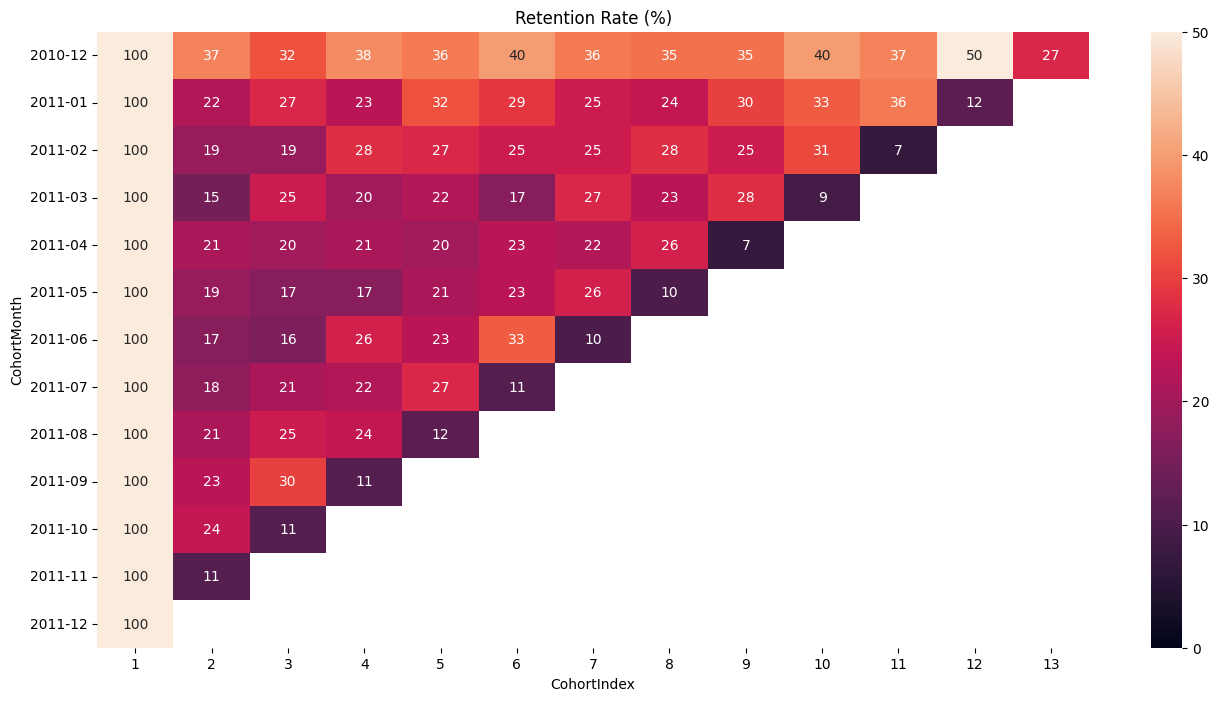

In [ ]:
# Retention Rate ------------------
cohort_size = cohort_count.iloc[:, 0]
retention = cohort_count.divide(cohort_size, axis=0)
retention = (retention.round(2) * 100)

# Plot retention heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(data=retention, annot=True, vmin=0, vmax=50, fmt='.0f')
plt.title("Retention Rate (%)")
plt.show()


## 9. Quantity Heatmap


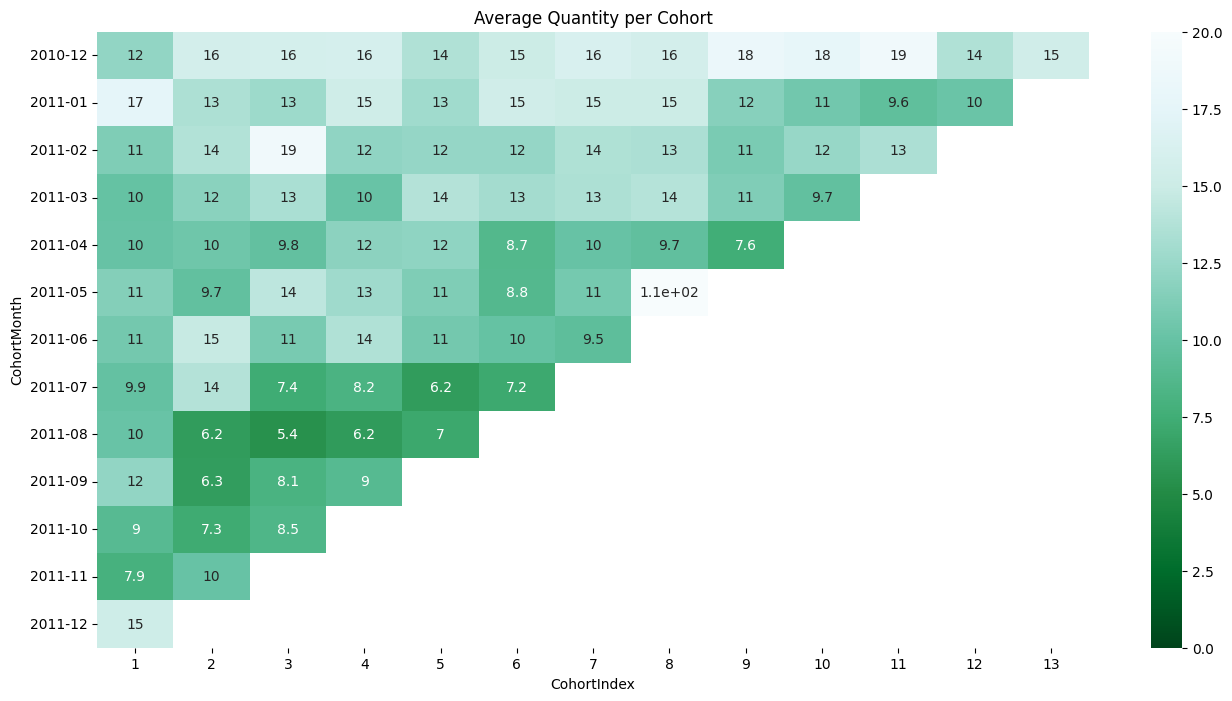

In [28]:
# Average Quantity per Cohort
cohort_quantity = df.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].mean().reset_index()
average_quantity = cohort_quantity.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')

# Plot quantity heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(data=average_quantity, annot=True, vmin=0, vmax=20, cmap="BuGn_r")
plt.title('Average Quantity per Cohort')
plt.show()
